**Coronavirus in the world**

In [3]:
import pandas as pd 
cases = pd.read_csv("C:\Users\KIIT\Desktop\coronavirus dataset.csv")
import plotly.offline as py
import plotly.express as px


py.init_notebook_mode(connected=True)

grp = cases.groupby(['ObservationDate', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max()
grp = grp.reset_index()
grp['Date'] = pd.to_datetime(grp['ObservationDate'])
grp['Date'] = grp['Date'].dt.strftime('%m/%d/%Y')
grp['Active'] = grp['Confirmed'] - grp['Recovered'] - grp['Deaths']
grp['Country'] =  grp['Country/Region']

fig = px.choropleth(grp, locations="Country", locationmode='country names', 
                     color="Confirmed", hover_name="Country/Region",hover_data = [grp.Recovered,grp.Deaths,grp.Active],projection="mercator",
                     animation_frame="Date",width=1000, height=700,
                     color_continuous_scale='Reds',
                     range_color=[1000,50000],

                     title='World Map of Coronavirus')

fig.update(layout_coloraxis_showscale=True)
py.offline.iplot(fig)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-3-0bb52daeb1d0>, line 2)

**Related Work**
* For Analysis and Prediction on Coronavirus(Italy), Click [here](https://www.kaggle.com/vanshjatana/analysis-and-prediction-on-coronavirus-italy?scriptVersionId=29892166)
*  For Analysis and Prediction on Coronavirus(Iran), Click [here](https://www.kaggle.com/vanshjatana/analysis-and-prediction-on-coronavirus-iran)
*  For Analysis and Prediction on Coronavirus(South-Korea), Click [here](https://www.kaggle.com/vanshjatana/analysis-on-coronavirus)
*  For report on Coronavirus, Click [here](https://www.researchgate.net/publication/339738108_Analysis_On_Coronavirus)

**Machine Learning Algorithms Applied**

1. K-Mean Clustering
2. Regression Model
3. Prophet
4. Arima 
5. LSTM 

**Libraries**

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
from datetime import date, timedelta
from sklearn.cluster import KMeans
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import plotly.offline as py
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


Using TensorFlow backend.


**Reading Data**

In [8]:
df_patient = pd.read_csv('PatientInfo.csv')
df_route = pd.read_csv('PatientRoute.csv')


NameError: name 'pd' is not defined

**Looking into patient data**

In [4]:
df_patient.head()

,id,sex,birth_year,country,region,group,infection_reason,infection_order,infected_by,contact_number,confirmed_date,released_date,deceased_date,state
0,1,female,1984.0,China,filtered at airport,NaN,visit to Wuhan,1.0,NaN,45.0,2020-01-20,2020-02-06,NaN,released
1,2,male,1964.0,Korea,filtered at airport,NaN,visit to Wuhan,1.0,NaN,75.0,2020-01-24,2020-02-05,NaN,released
2,3,male,1966.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,16.0,2020-01-26,2020-02-12,NaN,released
3,4,male,1964.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,95.0,2020-01-27,2020-02-09,NaN,released
4,5,male,1987.0,Korea,capital area,NaN,visit to Wuhan,1.0,NaN,31.0,2020-01-30,2020-03-02,NaN,released


1.  **id** the ID of the patient (n-th confirmed patient)
2.  **sex** the sex of the patient
3.  **birth_year** the birth year of the patient
4.  **country** the country of the patient
5.  **region** the region of the patient
6.  **group** the collective infection
7.  **infection_reason** the reason of infection
8.  **infection_order** the order of infection
9.  **infected_by** the ID of who has infected the patient
10. **contact_number** the number of contacts with people
11. **confirmed_date** the date of confirmation
12. **released_date** the date of discharge
13. **deceased_date** the date of decease
14. **state** isolated / released / deceased

In [5]:
df_patient.shape

(5328, 14)

In [6]:
df_patient.isna().sum()


id                     0
sex                 4945
birth_year          4958
country                0
region              4957
group               5247
infection_reason    5188
infection_order     5293
infected_by         5258
contact_number      5281
confirmed_date         0
released_date       5296
deceased_date       5308
state                  0
dtype: int64

**Preprocessing**

In [7]:
df_patient['birth_year'] = df_patient.birth_year.fillna(0.0).astype(int)
df_patient['birth_year'] = df_patient['birth_year'].map(lambda val: val if val > 0 else np.nan)
df_patient.confirmed_date = pd.to_datetime(df_patient.confirmed_date)
daily_count = df_patient.groupby(df_patient.confirmed_date).id.count()
accumulated_count = daily_count.cumsum()
df_patient['age'] = 2020 - df_patient['birth_year'] 
import math
def group_age(age):
    if age >= 0: # not NaN
        if age % 10 != 0:
            lower = int(math.floor(age / 10.0)) * 10
            upper = int(math.ceil(age / 10.0)) * 10 - 1
            return f"{lower}-{upper}"
        else:
            lower = int(age)
            upper = int(age + 9) 
            return f"{lower}-{upper}"
    return "Unknown"


df_patient["age_range"] = df_patient["age"].apply(group_age)

In [8]:
patient=df_patient

In [9]:
date_cols = ["confirmed_date", "released_date", "deceased_date"]
for col in date_cols:
    patient[col] = pd.to_datetime(patient[col])

In [10]:
patient["time_to_release_since_confirmed"] = patient["released_date"] - patient["confirmed_date"]
patient["time_to_death_since_confirmed"] = patient["deceased_date"] - patient["confirmed_date"]
patient["duration_since_confirmed"] = patient[["time_to_release_since_confirmed", "time_to_death_since_confirmed"]].min(axis=1)
patient["duration_days"] = patient["duration_since_confirmed"].dt.days
age_ranges = sorted(set([ar for ar in patient["age_range"] if ar != "Unknown"]))
patient["state_by_gender"] = patient["state"] + "_" + patient["sex"]
released = df_patient[df_patient.state == 'released']
isolated_state = df_patient[df_patient.state == 'isolated']
dead = df_patient[df_patient.state == 'deceased']


**Confirmed Cases**

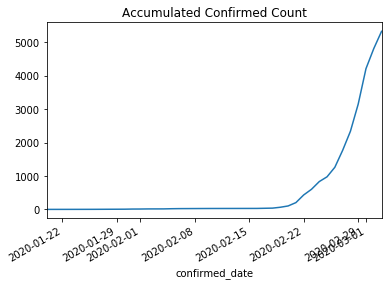

In [11]:
accumulated_count.plot()
plt.title('Accumulated Confirmed Count');

In [12]:
clus=df_route.loc[:,['id','latitude','longitude']]
clus.head(10)

,id,latitude,longitude
0,1,37.460459,126.440680
1,1,37.478832,126.668558
2,2,37.562143,126.801884
3,2,37.567454,127.005627
4,3,37.460459,126.440680
5,3,37.524978,127.027718
6,3,37.503359,127.049177
7,3,37.524669,127.015911
8,3,37.529200,127.032597
9,3,37.674192,126.776955


**Checking for number of cluster**

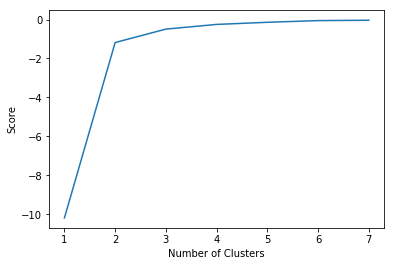

In [13]:
K_clusters = range(1,8)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df_route[['latitude']]
X_axis = df_route[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()



As in this graph, after 3 score go to constant value, so we will go with 3 clusters

**K-Mean Clusterning**

In [14]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(clus[clus.columns[1:3]])
clus['cluster_label'] = kmeans.fit_predict(clus[clus.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(clus[clus.columns[1:3]])

**Graphical representation of clusters**

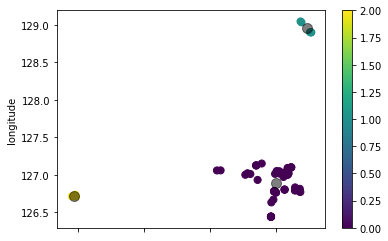

In [15]:
clus.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.5)


**World Map**

In [16]:
 import folium
southkorea_map = folium.Map(location=[36.55,126.983333 ], zoom_start=7,tiles='Stamen Toner')

for lat, lon,city in zip(df_route['latitude'], df_route['longitude'],df_route['city']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color='red',
                      popup =('City: ' + str(city) + '<br>'),
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(southkorea_map)
southkorea_map

**World Map Daily**

In [17]:
cmap1 = df_route
cmap1  = cmap1.groupby(['date', 'province','latitude','longitude'])['id'].max()


cmap1 = cmap1.reset_index()
cmap1.head()
cmap1['size'] = cmap1['id']*900
cmap1
fig = px.scatter_mapbox(cmap1, lat="latitude", lon="longitude",
                     color="id", size='size',
                     color_continuous_scale='burgyl',
                     animation_frame="date", 
                     title='Spread total cases over time')
fig.update(layout_coloraxis_showscale=True)
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=3)
fig.update_layout(margin={"r":0,"t":30,"l":0,"b":0})
fig.show()

In [18]:
data = daily_count.resample('D').first().fillna(0).cumsum()
data = data[20:]
x = np.arange(len(data)).reshape(-1, 1)
y = data.values

**Regression Model**

In [19]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=[32, 32, 10], max_iter=50000, alpha=0.0005, random_state=26)
_=model.fit(x, y)

In [20]:
test = np.arange(len(data)+7).reshape(-1, 1)
pred = model.predict(test)
prediction = pred.round().astype(int)
week = [data.index[0] + timedelta(days=i) for i in range(len(prediction))]
dt_idx = pd.DatetimeIndex(week)
predicted_count = pd.Series(prediction, dt_idx)

**Graphical representatoin of current confirmed and predicted confirmed**

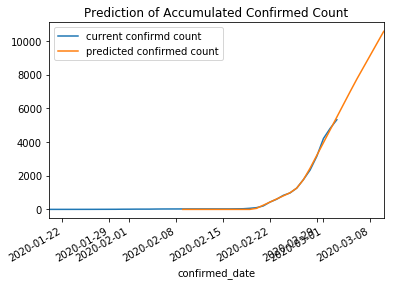

In [21]:
accumulated_count.plot()
predicted_count.plot()
plt.title('Prediction of Accumulated Confirmed Count')
plt.legend(['current confirmd count', 'predicted confirmed count'])
plt.show()

**Prophet**

**Making data ready for Prophet**

In [22]:
prophet= pd.DataFrame(data)
prophet
pr_data = prophet.reset_index()
pr_data.columns = ['ds','y']
pr_data

,ds,y
0,2020-02-09,27.0
1,2020-02-10,28.0
2,2020-02-11,28.0
3,2020-02-12,28.0
4,2020-02-13,28.0
5,2020-02-14,28.0
6,2020-02-15,28.0
7,2020-02-16,30.0
8,2020-02-17,30.0
9,2020-02-18,39.0


**Model and prediction**

In [23]:
m=Prophet()
m.fit(pr_data)
future=m.make_future_dataframe(periods=30)
forecast=m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-09,-1155.825903,-1865.612285,205.591689,-1155.825903,-1155.825903,355.579119,355.579119,355.579119,355.579119,355.579119,355.579119,0.0,0.0,0.0,-800.246784
1,2020-02-10,-963.640137,-1675.140393,513.275542,-963.640137,-963.640137,371.364637,371.364637,371.364637,371.364637,371.364637,371.364637,0.0,0.0,0.0,-592.275501
2,2020-02-11,-771.454371,-1515.914193,624.393780,-771.454371,-771.454371,346.150900,346.150900,346.150900,346.150900,346.150900,346.150900,0.0,0.0,0.0,-425.303471
3,2020-02-12,-579.268606,-1965.411444,174.665388,-579.268606,-579.268606,-314.629615,-314.629615,-314.629615,-314.629615,-314.629615,-314.629615,0.0,0.0,0.0,-893.898220
4,2020-02-13,-387.082840,-1733.722919,454.221692,-387.082840,-387.082840,-325.484037,-325.484037,-325.484037,-325.484037,-325.484037,-325.484037,0.0,0.0,0.0,-712.566877
5,2020-02-14,-194.897074,-1636.584306,602.223501,-194.897074,-194.897074,-294.042904,-294.042904,-294.042904,-294.042904,-294.042904,-294.042904,0.0,0.0,0.0,-488.939978
6,2020-02-15,-2.711308,-1225.038738,897.090730,-2.711308,-2.711308,-138.938101,-138.938101,-138.938101,-138.938101,-138.938101,-138.938101,0.0,0.0,0.0,-141.649409
7,2020-02-16,189.474458,-504.573368,1539.508108,189.474458,189.474458,355.579119,355.579119,355.579119,355.579119,355.579119,355.579119,0.0,0.0,0.0,545.053577
8,2020-02-17,381.660224,-361.995754,1818.121628,381.660224,381.660224,371.364637,371.364637,371.364637,371.364637,371.364637,371.364637,0.0,0.0,0.0,753.024860
9,2020-02-18,573.845990,-103.159231,2100.669104,573.845990,573.845990,346.150900,346.150900,346.150900,346.150900,346.150900,346.150900,0.0,0.0,0.0,919.996890


In [24]:
cnfrm = forecast.loc[:,['ds','trend']]
cnfrm = cnfrm[cnfrm['trend']>0]
cnfrm=cnfrm.tail(15)
cnfrm.columns = ['Date','Confirm']
cnfrm.head()

,Date,Confirm
39,2020-03-19,6339.569741
40,2020-03-20,6531.761053
41,2020-03-21,6723.952365
42,2020-03-22,6916.143677
43,2020-03-23,7108.334989


**Graphical Representation of Prediction**

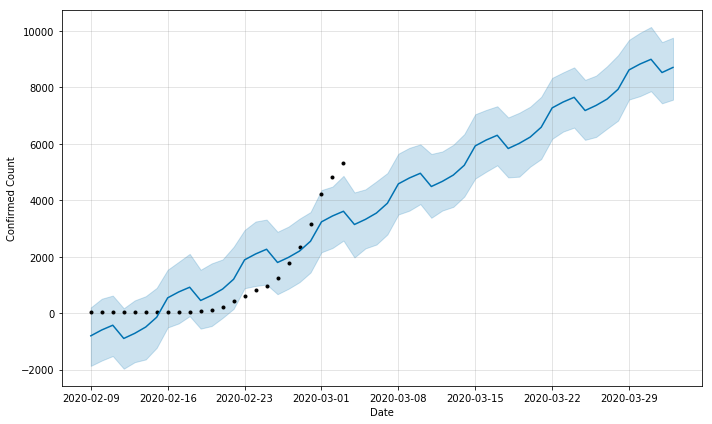

In [25]:
fig = plot_plotly(m, forecast)
py.iplot(fig) 

fig = m.plot(forecast,xlabel='Date',ylabel='Confirmed Count')


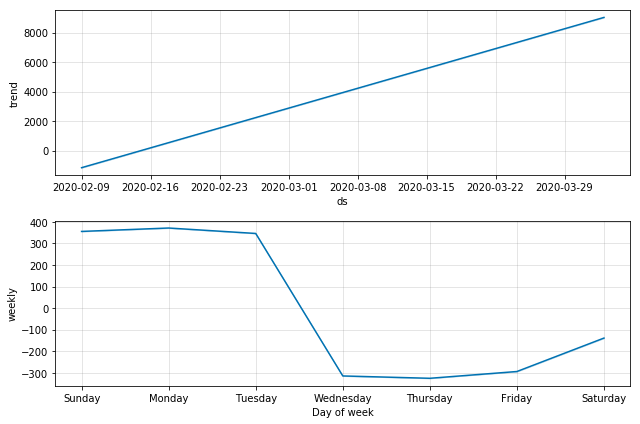

In [26]:
figure=m.plot_components(forecast)


**Autoregressive integrated moving average(Arima)**

**Making data ready for Arima**

In [27]:
confirm_cs = prophet.cumsum()
arima_data = confirm_cs.reset_index()
arima_data.columns = ['confirmed_date','count']
arima_data

,confirmed_date,count
0,2020-02-09,27.0
1,2020-02-10,55.0
2,2020-02-11,83.0
3,2020-02-12,111.0
4,2020-02-13,139.0
5,2020-02-14,167.0
6,2020-02-15,195.0
7,2020-02-16,225.0
8,2020-02-17,255.0
9,2020-02-18,294.0


** Model and prediction**

In [28]:
model = ARIMA(arima_data['count'].values, order=(1, 2, 1))
fit_model = model.fit(trend='c', full_output=True, disp=True)
fit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                   22
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -140.674
Method:                       css-mle   S.D. of innovations            140.003
Date:                Sat, 11 Apr 2020   AIC                            289.348
Time:                        12:18:47   BIC                            293.712
Sample:                             2   HQIC                           290.376
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        246.2801    174.991      1.407      0.159     -96.696     589.256
ar.L1.D2.y     0.8382      0.123      6.832      0.000       0.598       1.079
ma.L1.D2.y     0.1548      0.260      0.595      0.552      -0.355       0.665
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1930           +0.0000j            1.1930            0.0000
MA.1           -6.4593           +0.0000j            6.4593            0.5000
-----------------------------------------------------------------------------
"""

**Graphical Representation for Prediction**

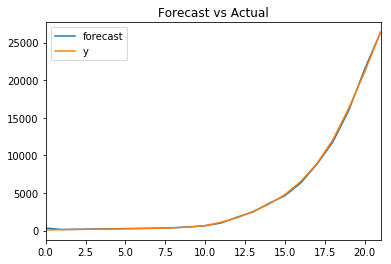

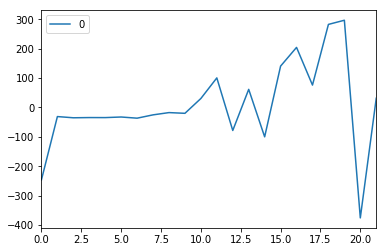

In [29]:
fit_model.plot_predict()
plt.title('Forecast vs Actual')
pd.DataFrame(fit_model.resid).plot()


Forcast for next 6 days

In [30]:
forcast = fit_model.forecast(steps=6)
pred_y = forcast[0].tolist()
pd.DataFrame(pred_y)

,0
0,32182.234955
1,38427.344458
2,45081.011709
3,52116.985868
4,59513.262562
5,67251.396956


**LSTM**

In [31]:
dataset = pd.DataFrame(data)
dataset.columns = ['Confirmed']
dataset.head()

,Confirmed
confirmed_date,
2020-02-09,27.0
2020-02-10,28.0
2020-02-11,28.0
2020-02-12,28.0
2020-02-13,28.0


**Splitting Data**

In [32]:
data = np.array(dataset).reshape(-1, 1)
train_data = dataset[:len(dataset)-5]
test_data = dataset[len(dataset)-5:]

In [33]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)
n_input =5
n_features =1
                             
generator = TimeseriesGenerator(scaled_train_data,scaled_train_data, length=n_input, batch_size=1)

lstm_model = Sequential()
lstm_model.add(LSTM(units = 50, return_sequences = True, input_shape = (n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50, return_sequences = True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units = 50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units = 1))
lstm_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
lstm_model.fit(generator, epochs = 20)

Epoch 1/20
14/14 [==============================] - 2s 115ms/step - loss: 0.1345
Epoch 2/20
14/14 [==============================] - 0s 8ms/step - loss: 0.0999
Epoch 3/20
14/14 [==============================] - 0s 9ms/step - loss: 0.0773
Epoch 4/20
14/14 [==============================] - 0s 12ms/step - loss: 0.0758
Epoch 5/20
14/14 [==============================] - 0s 9ms/step - loss: 0.0522
Epoch 6/20
14/14 [==============================] - 0s 9ms/step - loss: 0.0388
Epoch 7/20
14/14 [==============================] - 0s 9ms/step - loss: 0.0149
Epoch 8/20
14/14 [==============================] - 0s 9ms/step - loss: 0.0144
Epoch 9/20
14/14 [==============================] - 0s 9ms/step - loss: 0.0140
Epoch 10/20
14/14 [==============================] - 0s 9ms/step - loss: 0.0127
Epoch 11/20
14/14 [==============================] - 0s 9ms/step - loss: 0.0174
Epoch 12/20
14/14 [==============================] - 0s 8ms/step - loss: 0.0159
Epoch 13/20
14/14 [===========================

In [34]:
lstm_model.history.history.keys()


dict_keys(['loss'])

**Epochs vs Loss**

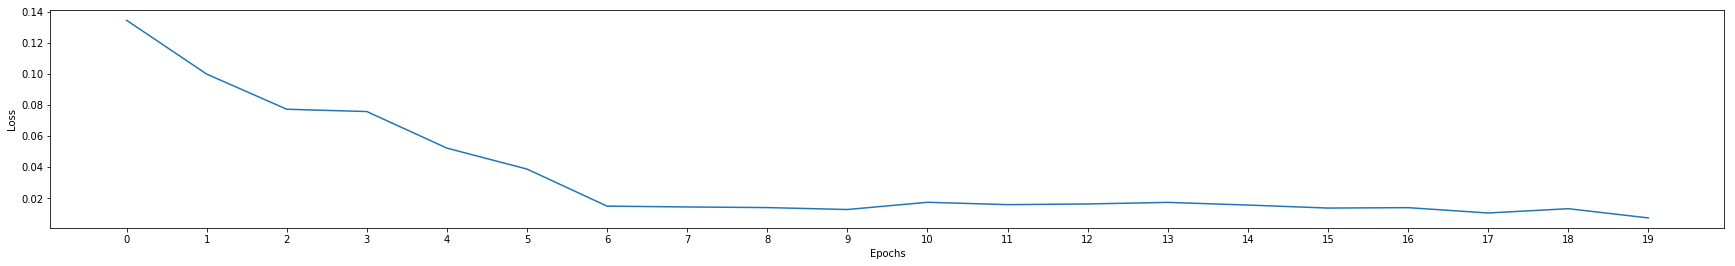

In [35]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize = (30,4))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(0,100,1))
plt.plot(range(len(losses_lstm)), losses_lstm)

In [36]:
lstm_predictions_scaled = []

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)


In [37]:
prediction = pd.DataFrame(scaler.inverse_transform(lstm_predictions_scaled))
prediction.head()

,0
0,2634.707473
1,3333.246601
2,4056.583755
3,4886.367858
4,5652.469536


**Prevention**
To avoid the critical situation people are suggested to do following things

* Avoid contact with people who are sick.
* Avoid touching your eyes, nose, and mouth.
* Stay home when you are sick.
* Cover your cough or sneeze with a tissue, then throw the tissue in the trash.
* Clean and disinfect frequently touched objects and surfaces using a regular household
* Wash your hands often with soap and water, especially after going to the bathroom; before eating; and after blowing your nose, coughing, or sneezing. If soap and water are not readily available, use an alcohol-based hand sanitizer.